# Bile Acids Data Processing

In [1]:
import pandas as pd
import numpy as np
import os
import random
from ipyfilechooser import FileChooser

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import Alignment, Font

pd.set_option('display.max_columns', 5000)

## Data file name

In [2]:
final_data_name = "test_101824"

## Pick and Load Configuration File

In [3]:
fc1 = FileChooser('')
fc1.show_only_dirs = False
display(fc1)

FileChooser(path='C:\Users\User\Documents\Bile acid python-101824\MetIDQ Export Processing', filename='', titl…

In [4]:
# Display selected folder
print(fc1.selected_filename)

Bile_Acids_Config.xlsx


In [5]:
ba_df = pd.read_excel(fc1.selected, "Analytes")
material_df = pd.read_excel(fc1.selected, "Materials")
qc_levels_df = pd.read_excel(fc1.selected, "QC")

# short cuts
ba = ba_df['Abbreviation']

## Pick and Load Met_IDQ file

In [6]:
fc2 = FileChooser('')
fc2.show_only_dirs = False
display(fc2)

FileChooser(path='C:\Users\User\Documents\Bile acid python-101824\MetIDQ Export Processing', filename='', titl…

In [70]:
# Display selected folder
print(fc2.selected_path)
print(fc2.selected_filename)

# Create Directory for plots
path = fc2.selected_path + "/plots"
isExist = os.path.exists(path)
if not isExist:
   os.makedirs(path)

# Create Directory for plots
path = fc2.selected_path + "/preprocessed_plots"
isExist = os.path.exists(path)
if not isExist:
   os.makedirs(path)

C:\Users\User\Documents\Bile acid python-101824
For python-A.txt


In [71]:
# read lines from text file
with open(fc2.selected, encoding='utf-8', errors='ignore') as inf:
    raw_data = inf.readlines()
    
# the greek mu is used for micro - causes error, replce with u    
raw_data = [line.replace('[M]', '[uM]') for line in raw_data]    
print(f'{fc2.selected} has {len(raw_data)} lines')

C:\Users\User\Documents\Bile acid python-101824\For python-A.txt has 105 lines


In [72]:
# get first comment row
first_row = raw_data[0].split('\t')
print(first_row)

['#WebIDQ-DB123-731 | Concentration [uM] | This export contains metabolism indicators', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '\n']


In [73]:
# get column names, and create empty dataframe
column_names = raw_data[1]
column_names = column_names.replace('"', '')
column_names = column_names.split('\t')
df = pd.DataFrame(columns = column_names)


# feed lines from text file into dataframe
for line in range(2,len(raw_data)):
    next_line = raw_data[line].split('\t')
    df.loc[len(df)] = next_line
print(f'Data has {df.shape[0]} rows and {df.shape[1]} columns')

Data has 103 rows and 100 columns


## Clean and separate data

In [74]:
# remove quotes
for i, col in enumerate(df.columns):
    df.iloc[:, i] = df.iloc[:, i].str.replace('"', '')

In [75]:
# remove status column, create new dataframe
df_clean = df.loc[:, ~df.columns.str.contains('Status', case=False)]
df_clean = df_clean.sort_values(by=['Material', 'Plate bar code', 'Sample type', 'Sample identification'])
print(f'Removed {df.shape[1] - df_clean.shape[1]} status columns')

Removed 40 status columns


In [76]:
#save ba indicators
df_ba_ind = df_clean.iloc[:,(df_clean.columns.get_loc(ba[len(ba)-1])+1):df_clean.shape[1]]

#remove ba indicators
df_clean = df_clean.iloc[:,0:(df_clean.columns.get_loc(ba[len(ba)-1])+1)]

In [77]:
# gather sample data and spqc data
df_data = df_clean[(df_clean['Plate bar code'] != "") &
                   (df_clean['Sample type'] == "Sample") &
                   (~df_clean['Sample description'].str.contains('SPQC', case=False)) &
                    (~df_clean['Sample identification'].str.contains('QC', case=False)) 
                  ]
df_spqc = df_clean[df_clean['Sample description'].str.contains('SPQC', case=False)]
df_qc = df_clean[df_clean['Sample identification'].str.contains('QC', case=False)]

# reset indexes for dataframes
df_data = df_data.reset_index(drop=True)
df_spqc = df_spqc.reset_index(drop=True)    
df_qc = df_qc.reset_index(drop=True)

# save copy with LOD
raw_clean_df = pd.concat([df_data, df_qc, df_spqc])

In [78]:
# gather LOD, LLOQ, ULOQ data from text file
df_lod = df_clean[df_clean['Measurement time'].str.contains('LOD')]
df_lloq = df_clean[df_clean['Measurement time'].str.contains('LLOQ')]
df_uloq = df_clean[df_clean['Measurement time'].str.contains('ULOQ')]

df_lod = df_lod.reset_index(drop=True)
df_lloq = df_lloq.reset_index(drop=True)
df_uloq = df_uloq.reset_index(drop=True)

# drop the first empty columns
df_lod = df_lod.replace("", float("NaN"))
df_lod = df_lod.dropna(how='all', axis=1)
df_lloq = df_lloq.replace("", float("NaN"))
df_lloq = df_lloq.dropna(how='all', axis=1)
df_uloq = df_uloq.replace("", float("NaN"))
df_uloq = df_uloq.dropna(how='all', axis=1)

In [79]:
# gather material and plate information from data file
materials = df_spqc['Material'].unique()
plates = df_spqc['Plate bar code'].unique()
print(f'There are {len(materials)} materials and {len(plates)} plates')

#create material abrev. list to be used throughout code
material_abr = []
for material in materials:
    material_abr.append(str(material_df[material_df['Material']==material]['Name'].values[0]))

There are 1 materials and 1 plates


## Data checks

In [80]:
# check bile acid analyte names and order 
test_ba = (ba == df_data.columns[(df_data.shape[1]-20):df_data.shape[1]])

if test_ba.all() == True:
    print('Bile Acid list and order matches data!')
else:
    print(f'Bile Acids mixed up -> {test_ba}')

Bile Acid list and order matches data!


In [81]:
# check material config to data 
if set(df_data['Material'].unique()).issubset(set(material_df['Material'])):
    print('All materials from data found in configuration!')
else:
    print('New material in data, please add to configuration!')

All materials from data found in configuration!


## Apply Dilution Factor

In [82]:
# loop through materials, isolate data, remove LOD string, apply factor, add LOD string, update original data
for material in materials:
    temp_df = df_data.loc[(df_data['Material']==material), ba]
    temp_df = temp_df.apply(pd.to_numeric, errors='coerce')
    #replace nan with 0
    temp_df = temp_df.fillna(0)
    #dil_factor = float(material_df[material_df['Material']== material]['Dilution'])
    dil_factor = material_df[material_df['Material']== material]['Dilution'].values[0]
    temp_df = temp_df * dil_factor
    #replace 0 with nan
    temp_df.replace(0, np.nan, inplace=True)
    #convert back to string and 
    temp_df = temp_df.astype(str)
    temp_df = temp_df.replace("nan", "<LOD", regex=True)
    df_data.loc[(df_data['Material']==material), ba] = temp_df

## Create Report Table Template

In [83]:
# Start build of report table
df_report = pd.DataFrame(columns = ["Bile Acid", "Abbreviation"])
df_report['Bile Acid'] = ba_df['Name']
df_report['Abbreviation'] = ba_df['Abbreviation']

# considate lod type to insure no ZERO's
df_lod_calc = df_lod[df_lod['Measurement time'].str.contains('calc')]
df_lod_op = df_lod[df_lod['Measurement time'].str.contains('from OP')]
df_lod_op.reset_index(inplace=True, drop=True)

for b in ba:
    for i in range(0, df_lod_calc.shape[0]):
        if float(df_lod_calc[b][i]) == 0:
            df_lod_calc.at[i, b] = df_lod_op[b][i]


# Loop through plates to transfer LOD info
for i in range(0, df_lod_calc.shape[0]):#fig, (ax1, ax2, ax3) = plt.subplots(3)
    lod_info = df_lod_calc.iloc[i].values
    df_report.insert(df_report.shape[1], lod_info[0], lod_info[1:df_lod_calc.shape[1]], True)  

# Transfer LLOQ info from first plate
lloq_info = df_lloq.iloc[0].values
df_report.insert(df_report.shape[1], "Lowest CS (uM)", lloq_info[1:df_lloq.shape[1]], True) 

# Transfer ULOQ info from first plate
uloq_info = df_uloq.iloc[0].values
df_report.insert(df_report.shape[1], "Higest CS (uM)", uloq_info[1:df_lloq.shape[1]], True) 



## Replace <LOD with LOD value from plate

In [84]:
use_fixed_LOD = False

# make sure LOD values read same
df_spqc[ba] = df_spqc[ba].replace(regex = [".*LOD"], value="<LOD")
df_data[ba] = df_data[ba].replace(regex = [".*LOD"], value="<LOD")
df_qc[ba] = df_qc[ba].replace(regex = [".*LOD"], value="<LOD")

if use_fixed_LOD:
    # Fixed LOD - use the single number analyte
    # Loop through bile acids, plates
    # one LOD per bile acid and plate, LOD same for different materials
    for b in ba:
        for plate in plates:
            lod_plate = df_spqc['Plate bar code'][i].split(" | ")
            new_lod = max(df_report[df_report['Abbreviation']==b].filter(like=lod_plate[0]).values[0][0], 
                         df_report[df_report['Abbreviation']==b].filter(like=lod_plate[1]).values[0][0])
            #replace LOD in spqc
            df_spqc.loc[(df_spqc['Plate bar code']==plate) & 
                        (df_spqc[b].str.contains('LOD')), b] = new_lod
            #replace LOD in data
            df_data.loc[(df_data['Plate bar code']==plate) & 
                        (df_data[b].str.contains('LOD')), b] = new_lod
            #replace LOD in qc
            df_qc.loc[(df_qc['Plate bar code']==plate) &
                      (df_qc[b].str.contains('LOD')), b] = new_lod
        
else:  
    # impute with value LOD * (random number between 0-1)
    # create list of random numbers between 0-1, list has seed so will always impute the set the same way
    random.seed(1234)
    rand_list = [random.random() for i in range(10000)]
    rand_count = 0

    for b in ba:
        #search through spqc data
        for i in range(df_spqc.shape[0]):
            if df_spqc[b][i]=='<LOD':
                lod_material = df_spqc['Material'][i]
                lod_plate = df_spqc['Plate bar code'][i]
                new_lod = df_report[df_report['Abbreviation']==b].filter(like=lod_plate).filter(like="calc").values[0][0]
                if float(new_lod) == 0:
                    new_lod = 0.001
                df_spqc.at[i,b]=float(new_lod) * rand_list[rand_count]
                rand_count +=1
        #search through data
        for i in range(df_data.shape[0]):
            if df_data[b][i]=='<LOD':
                lod_material = df_data['Material'][i]
                lod_plate = df_data['Plate bar code'][i]
                new_lod = df_report[df_report['Abbreviation']==b].filter(like=lod_plate).filter(like="calc").values[0][0]
                if float(new_lod) == 0:
                    new_lod = 0.001
                df_data.at[i,b]=float(new_lod) * rand_list[rand_count]
                rand_count +=1
        #search through qc data
        for i in range(df_qc.shape[0]):
            if df_qc[b][i]=='<LOD':
                lod_material = df_qc['Material'][i]
                lod_plate = df_qc['Plate bar code'][i]
                new_lod = df_report[df_report['Abbreviation']==b].filter(like=lod_plate).filter(like="calc").values[0][0]
                if float(new_lod) == 0:
                    new_lod = 0.001
                df_qc.at[i,b]=float(new_lod) * rand_list[rand_count]
                rand_count +=1        

## Create report tables with SPQC Avg, and %CV's

In [85]:
# loop through materials and create a new dataframe with above report template and new avg and %cv calculations
temp_df = df_report.copy()
for material in materials:

    calc_df = df_spqc.loc[(df_spqc["Material"] == material), ba]
    calc_df = calc_df.apply(pd.to_numeric)
    material_abr = str(material_df[material_df['Material']==material]['Name'].values[0])
    temp_df["Average " + material_abr + " SPQC(uM)"] = np.round(calc_df.mean().values, 3)
    temp_df["%CV " + material_abr + " SPQC(uM)"] = np.round(calc_df.std().values/calc_df.mean().values*100, 3)

df_report_combined = temp_df
print(f'Created combined report')

Created combined report


In [86]:
# creates indvidual report dataframes for each material
# loop through materials and create a new dataframe with above report template and new avg and %cv calculations
for material in materials:
    temp_df = df_report.copy()

    calc_df = df_spqc.loc[(df_spqc["Material"] == material), ba]
    calc_df = calc_df.apply(pd.to_numeric)
    material_abr = str(material_df[material_df['Material']==material]['Name'].values[0])
    temp_df["Average " + material_abr + " SPQC(uM)"] = np.round(calc_df.mean().values, 3)
    temp_df["%CV " + material_abr + " SPQC(uM)"] = np.round(calc_df.std().values/calc_df.mean().values*100, 3)

    globals()['df_report_' + material_abr] = temp_df
    print(f'Created report for {material_abr}')
    
    

Created report for Plasma


## Create data tables

In [87]:
# recombine data and spqc's
temp_df = pd.concat([df_data, df_spqc])

# loop through materials and create a new dataframe
for material in materials:
    material_abr = str(material_df[material_df['Material']==material]['Name'].values[0])
    globals()['df_data_' + material_abr] = temp_df[temp_df['Material'] == material]
    print(f'Created data table for {material_abr}')

Created data table for Plasma


## Creat QC Report

In [88]:
# Start build of report table
df_qc_report = pd.DataFrame(columns = ["Bile Acid", "Abbreviation"])
df_qc_report['Bile Acid'] = ba_df['Name']
df_qc_report['Abbreviation'] = ba_df['Abbreviation']

qc_levels = ['QC1', 'QC2', 'QC3']

In [89]:
# loop through qc levels 
for qc_level in qc_levels:
    # gather expected value
    df_qc_report[qc_level + ' Level (uM)'] = qc_levels_df[qc_levels_df['Expected values']==qc_level][ba].values[0]
    
    # gather qc data by plate, report uM and accuracy
    for plate in plates:
        temp_df = df_qc.loc[(df_qc['Plate bar code'] == plate) &
                   (df_qc['Sample identification'].str.contains(qc_level)), ba]
        temp_df = temp_df.apply(pd.to_numeric)
        df_qc_report[qc_level + ' ' + plate + ' Mean (uM)'] = temp_df.mean().values
        df_qc_report[qc_level + ' ' + plate + ' Accuracy'] =  round(
            df_qc_report[qc_level + ' ' + plate + ' Mean (uM)'] / df_qc_report[qc_level + ' Level (uM)'] * 100, 1)
        
        

In [90]:
#create summary report without uM Mean values
df_qc_report_summary = df_qc_report[df_qc_report.columns.drop(list(df_qc_report.filter(regex='Mean')))]

## Preprocess Data

In [91]:
spqc_filter = True
lod_filter = True

spqc_limit = 30
lod_limit = 0.5

#create copy unfiltered dataframe for filtered data
# loop through materials and create a new dataframe
for material in materials: 
    material_abr = str(material_df[material_df['Material']==material]['Name'].values[0])
    globals()['df_data_' + material_abr + '_filtered'] = globals()['df_data_' + material_abr].copy()


In [92]:
#Remove columns with SPQC %CV > Limit
if spqc_filter:
    # loop through materials and create a new dataframe
    for material in materials:  
        material_abr = str(material_df[material_df['Material']==material]['Name'].values[0])
        temp_df = globals()['df_data_' + material_abr + '_filtered'].copy()
        # loop through bile acids to check CV
        for b in ba:
            cv = df_report_combined.loc[df_report_combined['Abbreviation']==b, 
                                        ("%CV " + material_abr + " SPQC(uM)")].values
            if ((cv > spqc_limit) & (b in temp_df.columns)):
                temp_df.drop(b, axis=1, inplace = True)
        globals()['df_data_' + material_abr + "_filtered"] = temp_df
        print("Created data SPQC Filtered table for " + 
              f"{material_abr}, dropped {globals()['df_data_' + material_abr].shape[1]-temp_df.shape[1]}")       
    
    

Created data SPQC Filtered table for Plasma, dropped 2


In [93]:
#Remove columns with > X% (decimal) missing values (LOD)

if lod_filter:
    # force LOD text to always read same
    raw_clean_df[ba] = raw_clean_df[ba].replace(regex = [".*LOD"], value="<LOD")

    # loop through materials and create a new dataframe
    for material in materials:   
        material_abr = str(material_df[material_df['Material']==material]['Name'].values[0])
        lod_df = raw_clean_df[raw_clean_df['Material']==material].copy()
        temp_df = globals()['df_data_' + material_abr + '_filtered'].copy()
        for b in ba:
            if sum(lod_df[b]=="<LOD") > (lod_df.shape[0] * lod_limit ):
                try:
                    temp_df.drop(b, axis=1, inplace=True)
                except:
                    print(f"{b} Already dropped")

        print((f"Created data LOD table for {material_abr},") +
               (f" dropped {globals()['df_data_' + material_abr + '_filtered'].shape[1]-temp_df.shape[1]}")) 
        globals()['df_data_' + material_abr + "_filtered"] = temp_df
    

HDCA Already dropped
MCA(b) Already dropped
Created data LOD table for Plasma, dropped 1


## Send data to Excel

In [94]:
def add_combined_analysis_summary():
    #add combined data report
    ws = wb.create_sheet("Analysis Summary")    
    for r in dataframe_to_rows(df_report_combined, index=False, header=True):
        ws.append(r)
    align = Alignment(wrap_text=True, horizontal='center')
    ft = Font(bold=True)
    for row in ws['A1':'AA1']:
        for cell in row:
            cell.alignment = align
            cell.font = ft
    ws.column_dimensions['A'].width = 25

In [95]:
def add_indiv_analysis_summary():
    #add individual material data reports
    for material in materials:
        material_abr = str(material_df[material_df['Material']==material]['Name'].values[0])
        temp_df = globals()['df_report_' + material_abr]
        sheet_name = f"QC Summary {material_abr}"
        ws = wb.create_sheet(sheet_name)    
        for r in dataframe_to_rows(temp_df, index=False, header=True):
            ws.append(r)
        align = Alignment(wrap_text=True, horizontal='center')
        ft = Font(bold=True)
        for row in ws['A1':'AA1']:
            for cell in row:
                cell.alignment = align
                cell.font = ft
        ws.column_dimensions['A'].width = 25

In [96]:
def add_combined_qc_summary():
    #add qc report to excel        
    ws = wb.create_sheet("QC Summary")    
    for r in dataframe_to_rows(df_qc_report, index=False, header=True):
        ws.append(r)
    align = Alignment(wrap_text=True, horizontal='center')
    ft = Font(bold=True)
    for row in ws['A1':'AA1']:
        for cell in row:
            cell.alignment = align
            cell.font = ft
    ws.column_dimensions['A'].width = 25

In [97]:
def add_data():
    #add material data to excel
    for material in materials:
        material_abr = str(material_df[material_df['Material']==material]['Name'].values[0])
        temp_df = globals()['df_data_' + material_abr]
        sheet_name = f"{material_abr}"           
        ws = wb.create_sheet(sheet_name)    
        for r in dataframe_to_rows(temp_df, index=False, header=True):
            ws.append(r)
        align = Alignment(wrap_text=True, horizontal='center')
        ft = Font(bold=True)
        for row in ws['A1':'AA1']:
            for cell in row:
                cell.alignment = align
                cell.font = ft
        #ws.column_dimensions['A'].width = 15

In [98]:
def add_preprocessed():
    #add filtered/preprocessed data to excel
    for material in materials:
        material_abr = str(material_df[material_df['Material']==material]['Name'].values[0])
        temp_df = globals()['df_data_' + material_abr + "_filtered"]
        sheet_name = f"{material_abr} Preprocessed"
        ws = wb.create_sheet(sheet_name)    
        for r in dataframe_to_rows(temp_df, index=False, header=True):
            ws.append(r)
        align = Alignment(wrap_text=True, horizontal='center')
        ft = Font(bold=True)
        for row in ws['A1':'AA1']:
            for cell in row:
                cell.alignment = align
                cell.font = ft
        #ws.column_dimensions['A'].width = 15

In [99]:
#save excel to path of original raw data
path = f'{fc2.selected_path}/{final_data_name}.xlsx'

wb = Workbook()
ws = wb.active
ws.title = "Biocrates Export"
for line in raw_data:
    next_line = line.split('\t')
    ws.append(next_line)

   
add_combined_analysis_summary()   
add_combined_qc_summary()
add_data()
add_preprocessed()

wb.save(path)
wb.close()

## PCA

In [100]:
def scree_plot(pca, pca_material, ax=None, show_title=False):
    sns.set_style('whitegrid')
    ax = ax
    # Bar plot of explained_variance
    #fig = plt.figure(figsize = (8,8))
    ax.bar(
        range(1,len(pca.explained_variance_)+1),
        pca.explained_variance_
        )

    ax.plot(range(1,len(pca.explained_variance_ )+1),
             np.cumsum(pca.explained_variance_),c='red',
             label='Cumulative Explained Variance')

    ax.legend(loc='upper left')
    ax.grid(False)
    ax.set_xlabel('Number of components')
    ax.set_ylabel('Explained variance (eignenvalues)')
    if show_title:
        ax.set_title(f'{pca_material} Scree plot', fontsize = 16)

    #ax.savefig(f'{fc2.selected_path}/{pca_material}_ScreePlot.png')
    return(ax)

In [101]:
def pca_plot_old(pca_df, pca_material, ax=None, show_title=True):
    sns.set_style('whitegrid')
    #fig = plt.figure(figsize = (8,8))
    #ax = fig.add_subplot(1,1,1) 
    ax=ax
    ax.set_xlabel('PCA1', fontsize = 12)
    ax.set_ylabel('PCA2', fontsize = 12)
    if show_title:
        ax.set_title(f'{pca_material} PCA plot', fontsize = 16)
    targets = ['Sample', 'SPQC']
    colors = ['r', 'b']
    for target, color in zip(targets,colors):
        indicesToKeep = pca_df['target'] == target
        ax.scatter(pca_df.loc[indicesToKeep, 'PC1']
                   , pca_df.loc[indicesToKeep, 'PC2']
                   , c = color
                   , s = 50)
    ax.legend(targets)

    return(ax)

In [102]:
def load_plot(pca_material, xs, ys, feature_names, ax=None, show_title=False):
    # Plot the loadings on a scatterplot
    #ax = fig.add_subplot(1,1,1) 
    sns.set_style('whitegrid')
    ax = ax            
    for i, varnames in enumerate(feature_names):
        ax.scatter(xs[i], ys[i], s=200)
        ax.arrow(
            0, 0, # coordinates of arrow base
            xs[i], # length of the arrow along x
            ys[i], # length of the arrow along y
            color='grey', 
            head_width=0.01
            )
        ax.text(xs[i], ys[i], varnames)

    # Define the axes
    xticks = np.linspace(-0.8, 0.8, num=5)
    yticks = np.linspace(-0.8, 0.8, num=5)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xlabel('PC1', fontsize=12)
    ax.set_ylabel('PC2', fontsize=12)
    ax.grid(False)
    if show_title:
        ax.set_title(f'{pca_material} Loading Plot', fontsize = 16)
    return(ax)

In [103]:
def pca_plot(pca_df, pca_material, ax=None, show_title=True):
    sns.set_style('whitegrid')
    #fig = plt.figure(figsize = (8,8))
    #ax = fig.add_subplot(1,1,1) 
    
    pca_df_spqc = pca_df[pca_df['target'].str.contains('SPQC', case=False)]
    x_spqc = pca_df_spqc['PC1']
    y_spqc = pca_df_spqc['PC2']

    pca_df_sample = pca_df[pca_df['target'].str.contains('Sample', case=False)]
    x_sample = pca_df_sample['PC1']
    y_sample = pca_df_sample['PC2']

    ax=ax
    ax.set_xlabel('PCA1', fontsize = 12)
    ax.set_ylabel('PCA2', fontsize = 12)
    if show_title:
        ax.set_title(f'{pca_material} PCA plot', fontsize = 16)
    
    ax.scatter(x_spqc, y_spqc, c = 'b', s = 50, label='SPQC')
    ax.scatter(x_sample, y_sample, c = 'r', s = 50, label="Samples")
    ax.legend()

    return(ax)

In [104]:
def make_plots(use_preprocessed = False, scale_pca=False):
    #loop through materials - calc and plot pca's
    
    if use_preprocessed:
        plot_path = f'{fc2.selected_path}/preprocessed_plots/'
    else:
        plot_path = f'{fc2.selected_path}/plots/'   
        
    for material in materials:
        pca_material = str(material_df[material_df['Material']==material]['Name'].values[0])

        if use_preprocessed:
            data_for_pca = globals()['df_data_' + pca_material + '_filtered'] 
            plot_prefix = f'{pca_material}_Preprocessed'
        else:
            data_for_pca = globals()['df_data_' + pca_material] 
            plot_prefix = f'{pca_material}'

        #data_for_pca.reset_index(inplace=True)
        #debug line, comment out for normal runs...
        #data_for_pca = data_for_pca[data_for_pca['Sample description'].str.contains('SPQC', case=False)]
        
        #get list of analytes incase using filtered data
        pca_ba = list(set(ba.values) & set(data_for_pca.columns))
        pca_ba.sort()

        #clearly identify sample and spqc
        X = data_for_pca[pca_ba].apply(pd.to_numeric, errors = 'coerce')
        X.replace(0, 0.001, inplace=True)
        y = data_for_pca['Sample description']
        y = y.str.replace(".*SPQC", "SPQC", regex=True)
        y = y.str.replace("^((?!SPQC).)*$", "Sample", regex=True)

        # log data for PCA
        X = np.log2(X)
        # scale PCA
        if scale_pca:
            X = StandardScaler().fit_transform(X)

        # compute PCA
        pca = PCA(n_components=5) 
        pca_features = pca.fit_transform(X)
        pca_df = pd.DataFrame(
            data=pca_features, 
            columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
        pca_df['target'] = y.values

        # Principal components correlation coefficients
        loadings = pca.components_

        # Number of features before PCA
        n_features = pca.n_features_in_

        # Feature names before PCA
        feature_names = pca_ba

        # PC names
        pc_list = [f'PC{i}' for i in list(range(1, n_features + 1))]

        # Match PC names to loadings
        pc_loadings = dict(zip(pc_list, loadings))

        # Matrix of corr coefs between feature names and PCs
        load_all_df = pd.DataFrame.from_dict(pc_loadings)
        load_all_df['feature_names'] = feature_names
        load_all_df = load_all_df.set_index('feature_names')

        #get top 3 loadings from PC1 and PC2
        sorted_load = load_all_df
        sorted_load['PC1_abs'] = abs(sorted_load['PC1'])
        sorted_load['PC2_abs'] = abs(sorted_load['PC2'])

        sorted_load = sorted_load.sort_values(by=['PC1_abs'], ascending=False)
        PC1_load = sorted_load.head(3)

        sorted_load = sorted_load.sort_values(by=['PC2_abs'], ascending=False)
        PC2_load = sorted_load.head(3)

        load_top_df = pd.concat([PC1_load, PC2_load]).drop_duplicates()    


        # combined plot for report - Scree + PCA + Loading
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,7))
        scree_plot(pca, pca_material, ax1, show_title = False)
        pca_plot(pca_df, pca_material, ax2, show_title = False)
        load_plot(pca_material, load_top_df['PC1'].values, load_top_df['PC2'].values, 
                  load_top_df.index.values, ax3, show_title=False)
        fig.subplots_adjust(top=0.85, bottom=0.15, left=0.05, right=0.95)
        fig.suptitle(f'{pca_material} - Scree, PCA, and Loading Plot', fontsize = 20)
        plt.savefig(f'{plot_path}/{plot_prefix}_combined_plot.png')
        plt.show()
        plt.close()
        
        #save individual plots    
        fig, (ax1) = plt.subplots(1, 1, figsize=(7,7))
        scree_plot(pca, pca_material, ax1, show_title = True)
        fig.subplots_adjust(top=0.92, bottom=0.08, left=0.1, right=0.9)
        plt.savefig(f'{plot_path}/{plot_prefix}_scree.png')
        plt.close(fig)

        fig, (ax1) = plt.subplots(1, 1, figsize=(7,7))
        pca_plot(pca_df, pca_material, ax1, show_title = True)
        fig.subplots_adjust(top=0.92, bottom=0.08, left=0.1, right=0.9)
        plt.savefig(f'{plot_path}/{plot_prefix}_PCA.png')
        plt.close(fig)

        fig, (ax1) = plt.subplots(1, 1, figsize=(7,7))
        load_plot(pca_material, load_all_df['PC1'].values, load_all_df['PC2'].values, 
                  load_all_df.index.values, ax1, show_title=True)
        fig.subplots_adjust(top=0.92, bottom=0.08, left=0.1, right=0.9)
        plt.savefig(f'{plot_path}/{plot_prefix}_load_all_plot.png')
        plt.close(fig)

        fig, (ax1) = plt.subplots(1, 1, figsize=(7,7))
        load_plot(pca_material, load_top_df['PC1'].values, load_top_df['PC2'].values, 
                  load_top_df.index.values, ax1, show_title=True)
        fig.subplots_adjust(top=0.92, bottom=0.08, left=0.1, right=0.9)
        plt.savefig(f'{plot_path}//{plot_prefix}_load_top_plot.png')
        plt.close(fig)

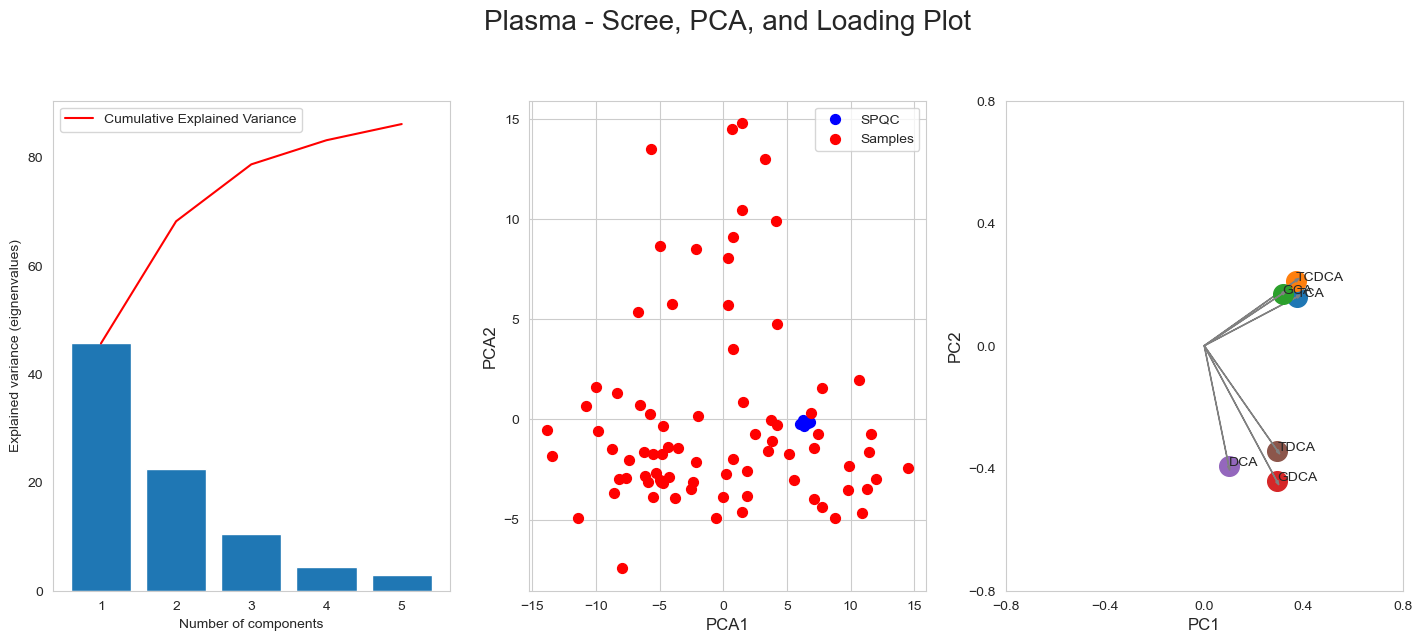

In [105]:
make_plots(use_preprocessed = False, scale_pca = False)

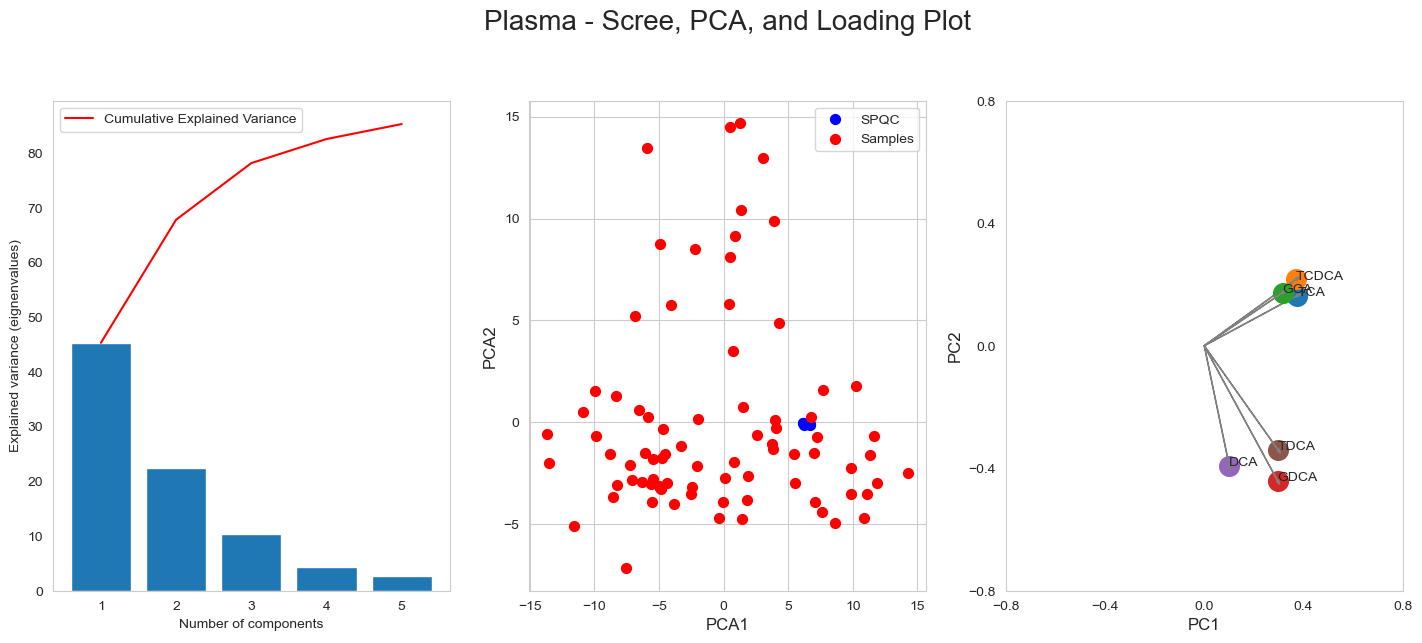

In [106]:
make_plots(use_preprocessed = True, scale_pca = False)

## SPQC Box Plot

In [68]:
cv_cols = [col for col in df_report_combined.columns if '%CV' in col]
temp_df = df_report_combined[cv_cols]

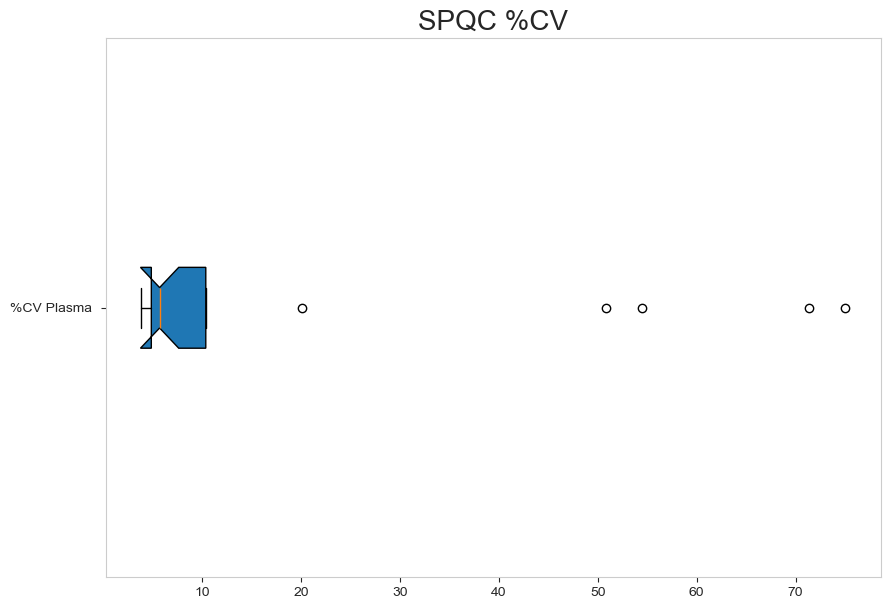

In [69]:
plot_path = f'{fc2.selected_path}/plots/'

fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)

bp = ax.boxplot(temp_df, patch_artist = True,
                notch ='True', vert = 0)

colors = [f'C{i}' for i in range(temp_df.shape[1])]

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    
plt.title("SPQC %CV", fontsize=20)
y_label = [sub.replace('SPQC(uM)', "") for sub in temp_df.columns.values]
ax.set_yticklabels(y_label, fontsize=10)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.grid(False)

plt.savefig(f'{plot_path}//SPQC_CV.png')
plt.show()

## SPQC Summary

In [ ]:
temp_df.head()

In [ ]:
temp2_df = pd.DataFrame(columns = ["Under", "Over"])
temp2_df['Under'] = temp_df[(temp_df <= 30)].count()
temp2_df['Over'] = temp_df[(temp_df >30)].count()

In [ ]:
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)

x = np.arange(temp2_df.shape[0])

width=0.4

ax.bar(x-.2, temp2_df['Under'], width, color="seagreen")
ax.bar(x+.2, temp2_df['Over'], width, color="firebrick")

xticks = [sub.replace(' Accuracy', "") for sub in temp2_df.index.to_list()]
ax.set_xticks(x, xticks)
ax.set_xlabel("QC", fontsize=20)
ax.set_ylabel("Count", fontsize=20)
ax.grid(False)
plt.legend(['<30% Accuracy', '>30% Accuracy'])
plt.title("SPQC Summary", fontsize=20)
plt.savefig(f'{plot_path}//SPQC_Summary.png')
plt.show()

## QC Boxplot

In [ ]:
cv_cols = [col for col in df_qc_report.columns if 'Accuracy' in col]
temp_df = df_qc_report[cv_cols]

In [ ]:
plot_path = f'{fc2.selected_path}/plots/'

fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)

bp = ax.boxplot(temp_df, patch_artist = True,
                notch ='True', vert = 0)

colors = [f'C{i}' for i in range(temp_df.shape[1])]

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    
plt.title("QC Accuracy", fontsize=20)
y_label = [sub.replace(' Accuracy', "") for sub in temp_df.columns.values]
ax.set_yticklabels(y_label, fontsize=10)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.grid(False)

plt.savefig(f'{plot_path}//QC_CV.png')
plt.show()

## QC Summary Plot

In [ ]:
temp2_df = pd.DataFrame(columns = ["Under", "Over"])
temp2_df['Under'] = temp_df[(temp_df >= 70) &  (temp_df <= 130)].count()
temp2_df['Over'] = temp_df[(temp_df < 70) |  (temp_df > 130)].count()

In [ ]:
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)

x = np.arange(temp2_df.shape[0])

width=0.4

ax.bar(x-.2, temp2_df['Under'], width, color="seagreen")
ax.bar(x+.2, temp2_df['Over'], width, color="firebrick")

xticks = [sub.replace(' Accuracy', "") for sub in temp2_df.index.to_list()]
ax.set_xticks(x, xticks, rotation=45)
ax.set_xlabel("QC", fontsize=20)
ax.set_ylabel("Count", fontsize=20)
ax.grid(False)
plt.legend(['<30% Accuracy', '>30% Accuracy'])
plt.title("QC Summary", fontsize=20)
plt.savefig(f'{plot_path}//QC_Summary.png')
plt.show()